In [316]:
import pandas
import matplotlib.pyplot as plt
import pickle
import wntr
from testWN import testWN as twm
import numpy as np
import pandas as pd

from sklearn.cluster import AgglomerativeClustering, FeatureAgglomeration

In [2]:
%matplotlib notebook

In [96]:
inp_file = '../Networks/BWCNdata/c-town_true_network.inp'
ctown = twm(inp_file)
node_names_all = ctown.wn.node_name_list
node_names = ctown.getNodeName()
link_names = ctown.getLinkName()

n_junctions = len(node_names[2])
n_nodes = len(node_names_all)


# Get Connectivity Matrix

In [109]:
A = np.zeros((n_junctions,n_junctions))
links = ctown.wn.links.todict()
for key in links.keys():
    i = np.where([np.array(node_names[2]) == links[key]['start_node_name']])[1]
    j = np.where([np.array(node_names[2]) == links[key]['end_node_name']])[1]
    
    A[i,j] = 1
    A[j,1] = 1

<IPython.core.display.Javascript object>


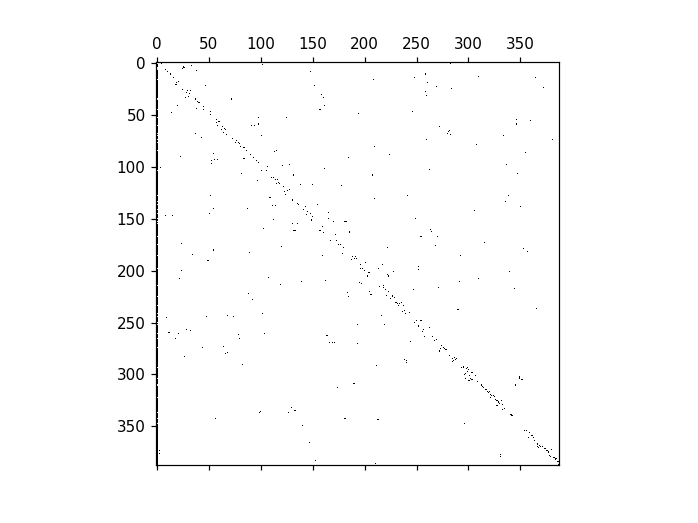

In [110]:
plt.figure()
plt.spy(A)

# Get Coordinates of nodes:

In [226]:
nodes = ctown.wn.nodes.todict()

In [281]:
coords = np.array([nodes[key]['coordinates'] for key in nodes.keys()])
coords_rep = np.repeat(coords,240, axis=1)
coords = pd.DataFrame(coords_rep, index=node_names_all)
junction_coords = coords.loc[node_names[2]]

# Clustering

In [282]:
with open('results.pkl', 'rb') as f:
    results=pickle.load(f)

In [283]:
press_junctions =results.node['pressure'][node_names[2]]
qual_junctions = results.node['quality'][node_names[2]]

In [284]:
press_junctions /=press_junctions.max()
qual_junctions /=qual_junctions.max()
junction_coords /= junction_coords.max()

In [358]:
X = np.concatenate((press_junctions.to_numpy(),
               qual_junctions.to_numpy(),
               junction_coords.to_numpy().T)).T

In [379]:
clustering = AgglomerativeClustering(n_clusters=20, connectivity=A, linkage='ward').fit(X)

In [380]:
cluster_labels = pd.DataFrame(clustering.labels_, index=node_names[2])

cluster_label_tot = pd.DataFrame(np.nan*np.zeros(n_nodes), index=node_names_all)
cluster_label_tot.loc[cluster_labels.index.to_list()] = cluster_labels

<IPython.core.display.Javascript object>


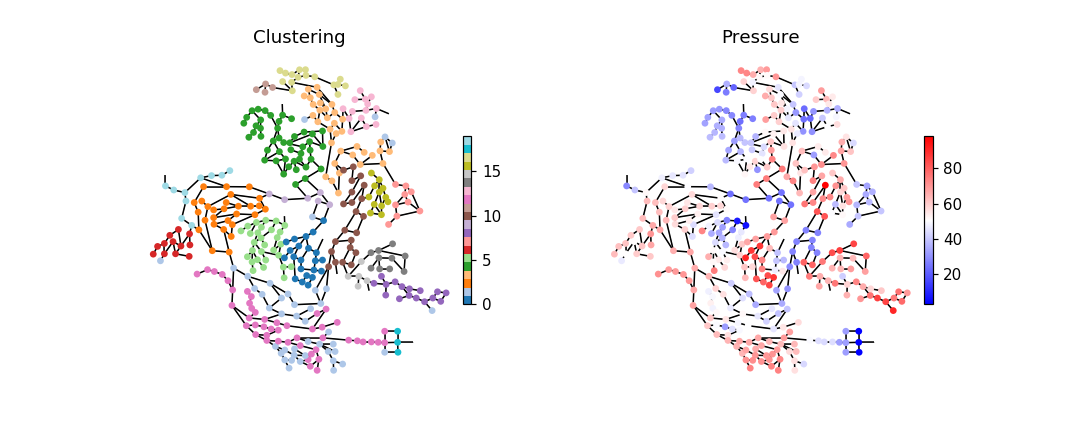

(<matplotlib.collections.PathCollection at 0x7f8cf46a89d0>,
 <matplotlib.collections.LineCollection at 0x7f8cf4678610>)

In [381]:
fig_1, ax_1 = plt.subplots(1,2, figsize=(10,4), sharex=True, sharey=True)
press = results.node['pressure']
press_med = press.mean()
wntr.graphics.plot_network(ctown.wn, node_attribute=cluster_label_tot[0], node_labels=False, node_cmap='tab20', title='Clustering', ax=ax_1[0])  # clustering
wntr.graphics.plot_network(ctown.wn, node_attribute=press_med[node_names[2]], node_cmap='bwr', title='Pressure', ax=ax_1[1])  # junctions